In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.neural_network import MLPClassifier
from sklearn.multioutput import MultiOutputClassifier

from sklearn.metrics import (
    f1_score,
    classification_report,
    precision_recall_curve,
    roc_curve,
    auc,
    multilabel_confusion_matrix
)

from sklearn.inspection import permutation_importance

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv("novel_processed(1).csv")
df_aug = pd.read_csv("novel_processed.csv")

label_cols = [
    '版权_电视剧签约',
    '版权_广播剧签约',
    '版权_网络剧签约',
    '版权_衍生品签约',
    '版权_有声读物签约'
]



In [3]:
def clean_df(df, label_cols):
    df = df.copy()

    year_cols = ['发表时间']
    df = df.drop(columns=[c for c in year_cols if c in df.columns], errors='ignore')

    text_cols = []
    for col in df.columns:
        if df[col].dtype == object:
            if df[col].astype(str).str.contains('[\u4e00-\u9fa5]', regex=True).any():
                if df[col].astype(str).str.len().max() > 20:
                    text_cols.append(col)
    df = df.drop(columns=text_cols, errors='ignore')

    object_cols = df.select_dtypes(include=['object']).columns.tolist()

    cat_cols = [
        col for col in object_cols
        if col not in label_cols and df[col].nunique() < 50
    ]
    df = pd.get_dummies(df, columns=cat_cols, dummy_na=True)

    residual_object_cols = df.select_dtypes(include=['object']).columns.tolist()
    df = df.drop(columns=residual_object_cols, errors='ignore')

    bad_cols = []
    for col in df.columns:
        try:
            df[col].astype(float)
        except:
            bad_cols.append(col)
    df = df.drop(columns=bad_cols, errors='ignore')

    return df

In [4]:
fingerprint_cols = ['字数', '总书评数', '文章积分'] 
df_clean = clean_df(df, label_cols)
df_aug_clean = clean_df(df_aug, label_cols)

In [5]:
df_aug_clean = df_aug_clean.reindex(columns=df_clean.columns, fill_value=0)

In [6]:
X_clean = df_clean.drop(columns=label_cols)
y_clean = df_clean[label_cols]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_clean, test_size=0.3, random_state=42
)

In [8]:
X_aug = df_aug_clean.drop(columns=label_cols)
y_aug = df_aug_clean[label_cols]

print("Checking for leakage between Test Set and Augmented Data...")

test_fingerprints = X_test[fingerprint_cols].astype(str).apply(lambda x: '_'.join(x), axis=1).unique()
test_fingerprints_set = set(test_fingerprints)

aug_fingerprints = X_aug[fingerprint_cols].astype(str).apply(lambda x: '_'.join(x), axis=1)

is_leakage = aug_fingerprints.apply(lambda x: x in test_fingerprints_set)

print(f"Found {is_leakage.sum()} leaking samples in Augmented Data. Removing them...")

X_aug_safe = X_aug[~is_leakage]
y_aug_safe = y_aug[~is_leakage]

X_train_full = pd.concat([X_train, X_aug_safe], axis=0).reset_index(drop=True)
y_train_full = pd.concat([y_train, y_aug_safe], axis=0).reset_index(drop=True)

print("Final Training Size:", X_train_full.shape)

Checking for leakage between Test Set and Augmented Data...
Found 135 leaking samples in Augmented Data. Removing them...
Final Training Size: (62019, 373)


In [10]:
print("X_train_full:", X_train_full.shape)
print("y_train_full:", y_train_full.shape)

X_train_full: (62019, 373)
y_train_full: (62019, 5)


In [11]:
scaler = StandardScaler()
X_train_trans = scaler.fit_transform(X_train_full)
X_test_trans = scaler.transform(X_test)

## 6. Train MLP Model / 训练MLP模型

In [12]:
from sklearn.neural_network import MLPClassifier
from sklearn.multioutput import MultiOutputClassifier

clf = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    activation='relu',
    max_iter=200,
    random_state=42,
    learning_rate='adaptive',
    alpha=1e-4,
    dropout=0.2,
    verbose=True
)

clf.fit(X_train_trans, y_train_full)

print("model trained")

Iteration 1, loss = 0.29179549
Iteration 2, loss = 0.09719053
Iteration 3, loss = 0.06984945
Iteration 4, loss = 0.05488066
Iteration 5, loss = 0.04369677
Iteration 6, loss = 0.03581976
Iteration 7, loss = 0.02938001
Iteration 8, loss = 0.02381002
Iteration 9, loss = 0.01974947
Iteration 10, loss = 0.01671037
Iteration 11, loss = 0.01377802
Iteration 12, loss = 0.01265204
Iteration 13, loss = 0.01063142
Iteration 14, loss = 0.00851506
Iteration 15, loss = 0.00783121
Iteration 16, loss = 0.00721822
Iteration 17, loss = 0.00633346
Iteration 18, loss = 0.00509537
Iteration 19, loss = 0.00471564
Iteration 20, loss = 0.00416769
Iteration 21, loss = 0.00504100
Iteration 22, loss = 0.00435905
Iteration 23, loss = 0.00272521
Iteration 24, loss = 0.00315957
Iteration 25, loss = 0.00288482
Iteration 26, loss = 0.00311954
Iteration 27, loss = 0.00271268
Iteration 28, loss = 0.00402547
Iteration 29, loss = 0.00675411
Iteration 30, loss = 0.00298101
Iteration 31, loss = 0.00351702
Iteration 32, los

## 7. Evaluate Model / 评估模型

In [13]:
from sklearn.metrics import f1_score, classification_report, precision_recall_curve, auc
y_pred = clf.predict(X_test_trans)
y_prob = clf.predict_proba(X_test_trans)

auprc_scores = {}

for i, col in enumerate(label_cols):
    probs = y_prob[:, i]
    precision, recall, _ = precision_recall_curve(y_test[col], probs)
    auprc = auc(recall, precision)
    auprc_scores[col] = auprc

print("\n========== 多标签评价 ==========")
print("micro F1:", f1_score(y_test, y_pred, average="micro"))
print("macro F1:", f1_score(y_test, y_pred, average="macro"))

print("\nAUPRC 分数：")
for k, v in auprc_scores.items():
    print(f"{k}: {v:.3f}")

print("\n分类报告：")
print(classification_report(y_test, y_pred, target_names=label_cols))




========== 多标签评价 ==========
micro F1: 0.3258426966292135
macro F1: 0.30206018752078684

AUPRC 分数：
版权_电视剧签约: 0.227
版权_广播剧签约: 0.267
版权_网络剧签约: 0.357
版权_衍生品签约: 0.064
版权_有声读物签约: 0.158

分类报告：
              precision    recall  f1-score   support

    版权_电视剧签约       0.38      0.33      0.35        18
    版权_广播剧签约       0.42      0.34      0.38        29
    版权_网络剧签约       0.35      0.27      0.30        30
    版权_衍生品签约       0.17      0.20      0.18         5
   版权_有声读物签约       0.40      0.24      0.30        17

   micro avg       0.37      0.29      0.33        99
   macro avg       0.34      0.28      0.30        99
weighted avg       0.37      0.29      0.33        99
 samples avg       0.00      0.00      0.00        99



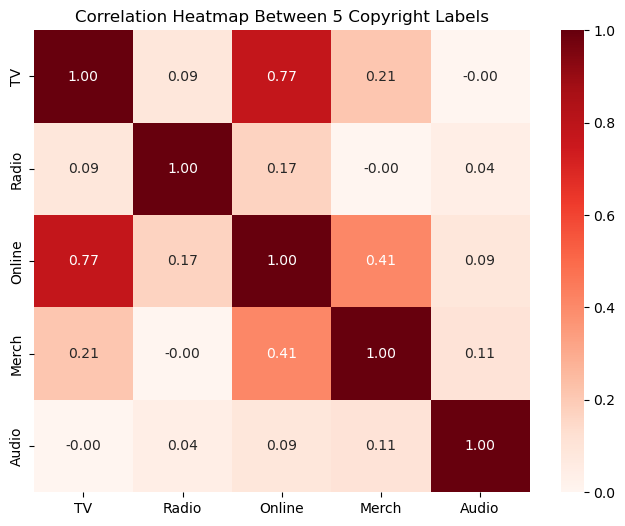

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt


label_map = {
    '版权_电视剧签约': 'TV', 
    '版权_广播剧签约': 'Radio',
    '版权_网络剧签约': 'Online',
    '版权_衍生品签约': 'Merch',
    '版权_有声读物签约': 'Audio'
}

plt.figure(figsize=(8, 6))

corr = y_test[label_cols].corr()

corr_english = corr.rename(index=label_map, columns=label_map)

sns.heatmap(corr_english, annot=True, cmap="Reds", fmt=".2f")
plt.title("Correlation Heatmap Between 5 Copyright Labels")
plt.show()



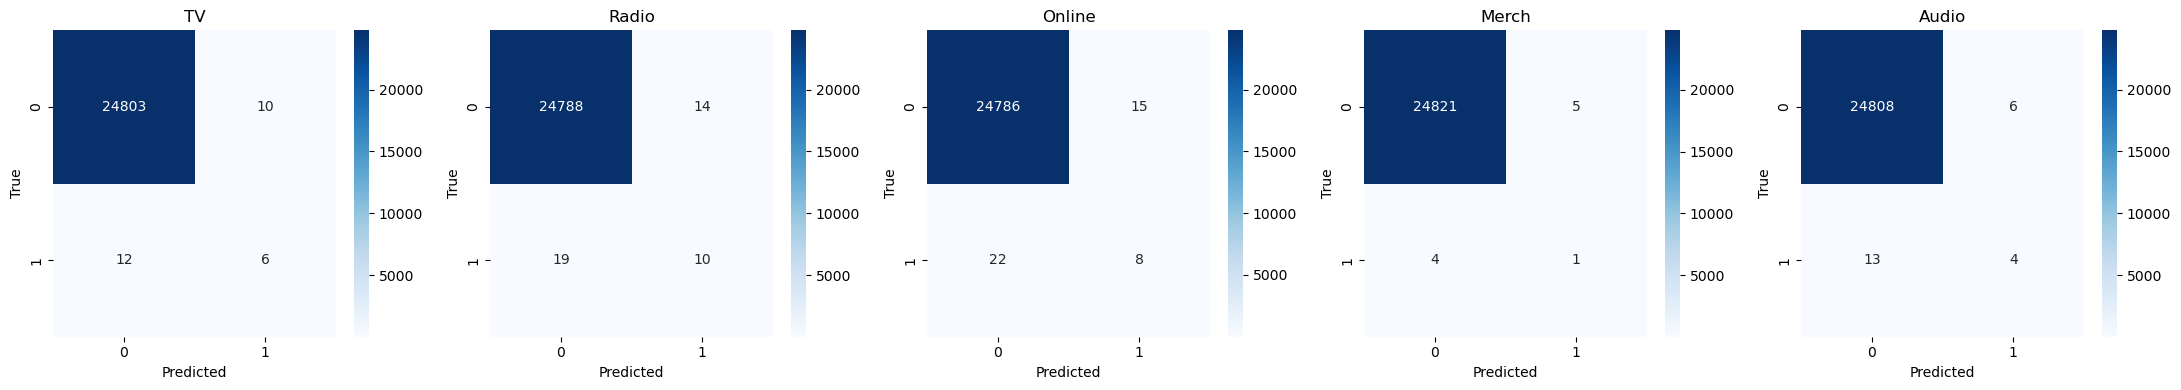

In [16]:
from sklearn.metrics import multilabel_confusion_matrix

label_map = {
    '版权_电视剧签约': 'TV', 
    '版权_广播剧签约': 'Radio',
    '版权_网络剧签约': 'Online',
    '版权_衍生品签约': 'Merch',
    '版权_有声读物签约': 'Audio'
}

cm = multilabel_confusion_matrix(y_test, y_pred)

fig, axes = plt.subplots(1, 5, figsize=(22, 4))

for i, (ax, col) in enumerate(zip(axes, label_cols)):
    c = cm[i]
    sns.heatmap(c, annot=True, fmt="d", cmap="Blues", ax=ax)
    ax.set_title(label_map[col])
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")

plt.tight_layout()
plt.show()

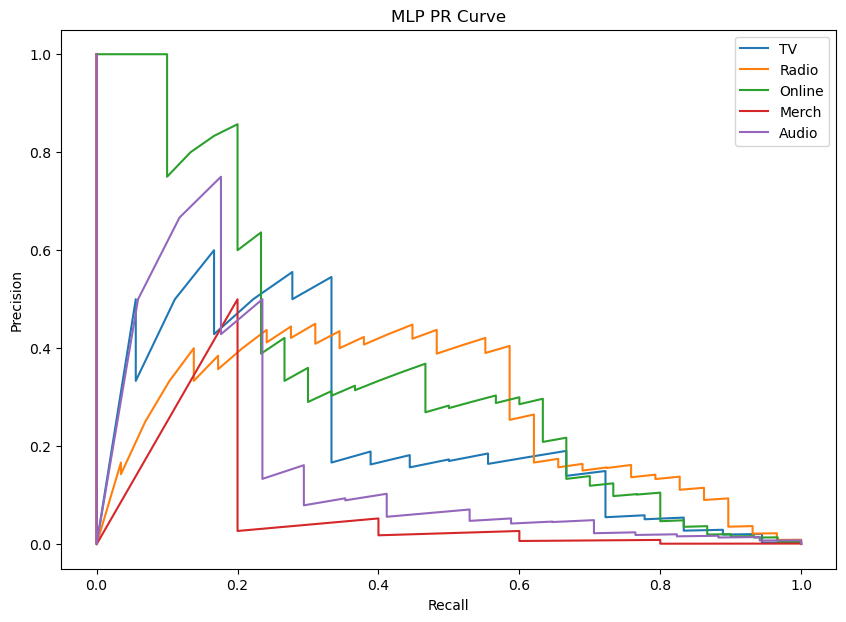

In [20]:
plt.figure(figsize=(10, 7))

label_map = {
    '版权_电视剧签约': 'TV', 
    '版权_广播剧签约': 'Radio',
    '版权_网络剧签约': 'Online',
    '版权_衍生品签约': 'Merch',
    '版权_有声读物签约': 'Audio'
}

for i, col in enumerate(label_cols):
    precision, recall, _ = precision_recall_curve(y_test[col], y_prob[:, i])
    plt.plot(recall, precision, label=label_map[col])

plt.title("MLP PR Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()


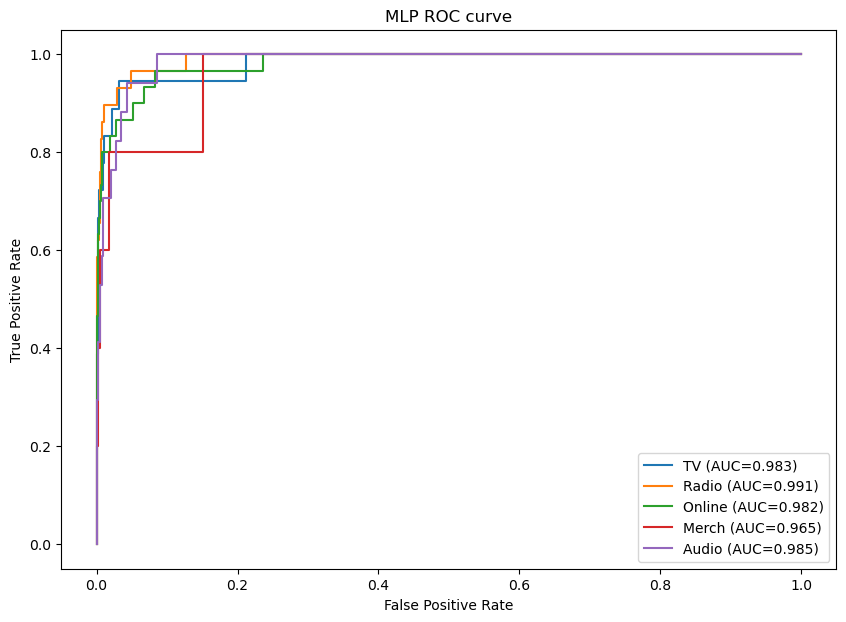

In [25]:
from sklearn.metrics import roc_curve, auc

label_map = {
    '版权_电视剧签约': 'TV', 
    '版权_广播剧签约': 'Radio',
    '版权_网络剧签约': 'Online',
    '版权_衍生品签约': 'Merch',
    '版权_有声读物签约': 'Audio'
}

plt.figure(figsize=(10, 7))

for i, col in enumerate(label_cols):
    fpr, tpr, _ = roc_curve(y_test[col], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label_map[col]} (AUC={roc_auc:.3f})")

plt.title("MLP ROC curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()
